### Libraries

In [1]:
import csv
import pandas as pd
import numpy as np

import json
import requests
from urllib.request import urlopen
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
import seaborn as sns

# Function 'api_nass( )' to collect data from USDA-NASS API
### Provide a dictionary of parameters and api-key: api_nass(api_params, key)
### Function returns a pandas dataframe

In [2]:
# http direction 
nass_base = 'http://quickstats.nass.usda.gov/api/api_GET?'
# My personal key
key= '1897574B-86B2-3182-B9C3-3BFF302E3042'
# Function
def api_nass(api_params, key):
    apidata = requests.get(nass_base, params=api_params)
    apidata = apidata.json()
    df = pd.DataFrame.from_dict(apidata['data'])
    return df

## Function to plot cloropleth map by county:
### df= DataFrame
### fips_code= column name of location
### var= column name of variable of interest
### title= title in strings
### range_col= series range, ex. (0, 1)
### palette= color palette, ex. 'Viridis'

In [3]:
## Geojson file of counties
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as req:
    counties = json.load(req)
    
def map_county(df, fips_code, var, title, range_col, palette):

    fig = px.choropleth(df, geojson=counties, locations=fips_code, color=var,
                               color_continuous_scale=palette,
                               range_color=range_col,
                               scope="usa",
                               labels={var:title}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

## Function to integrate Lorenz curve (with tabulated data) applying Trapezoid Integration Method

In [4]:
def integrate(x, y):
    area = np.trapz(y=y, x=x)
    return area



# Ag Land, crops, harvested, size distribution

In [5]:
dfsize = pd.DataFrame(columns=['year','state_fips_code','state_name','county_ansi','county_name','domaincat_desc'])
for y in [2012, 2017]:
    dfa = pd.DataFrame(columns=['year','state_fips_code','state_name','county_ansi','county_name','domaincat_desc'])
    for z in ['FARM OPERATIONS - ACRES OPERATED','FARM OPERATIONS - NUMBER OF OPERATIONS']:
        label= z[18:23]
        # Parameters for land tenure data
        area_params = {'key': key,
                   'sector_desc': 'ECONOMICS',
                   'commodity_desc': 'FARM OPERATIONS',
                   'domain_desc': 'AREA OPERATED',
                   'short_desc': z,
                   'agg_level_desc': 'COUNTY',
                   'year': y}
        df= api_nass(area_params, key)
        df[label]= df['Value'].str.replace(',', '')
        df[label]= pd.to_numeric(df[label], errors='coerce')

        # merge number of operations (farms) with area
        
        filt=['year','state_name','county_name','state_fips_code','county_ansi','domaincat_desc',label]

        dfa=dfa.merge(df[filt], how='outer', on=['year','state_fips_code','state_name','county_ansi','county_name','domaincat_desc'])           

    dfsize=dfsize.append(dfa, 'sort=False')

In [13]:
#Select categories
types=dfsize['domaincat_desc'].unique().tolist()
selection=[]
for i in [0, 1, 2, 3,4,5,6,7,8,9,10,11]:
    selection.append(types[i])
# New dataset with selected categories of land size    
dfsize1= dfsize.loc[dfsize['domaincat_desc'].isin(selection)]

#bool1 = pd.isnull(dfsize1['ACRES'])
#dfsize1[bool1]

In [14]:
# MISSING VALUES Strategy: replace nan with mid-point of land size category 
#Define upper and lower bounds of land size tabulated data
# Extract numbers (acres) from column: categories description
dfsize1['domaincat_desc']= dfsize1['domaincat_desc'].str.replace(',', '', regex=True)
dfsize1['domaincat_desc']= dfsize1['domaincat_desc'].str.replace('.0', '', regex=False)
dfsize1['domaincat_desc']= dfsize1['domaincat_desc'].str.replace('.9', '', regex=False)

dfs = dfsize1['domaincat_desc'].str.findall(r'\b\d+\b').to_frame()
dfsize1['lower_bound']= dfs.apply(lambda x: x.str[0])
dfsize1['upper_bound']= dfs.apply(lambda x: x.str[1])

dfsize1['lower_bound']=dfsize1['lower_bound'].astype(int)
dfsize1['upper_bound']= pd.to_numeric(dfsize1['upper_bound'], errors='coerce')

# Replace missing values in Acres with the midpoint of the upper and lower bounds of the tabulated data of acres 
dfsize1['ACRES']= dfsize1['ACRES'].fillna((dfsize1['lower_bound']+dfsize1['upper_bound'])*(dfsize1['NUMBE'])/2)

#Impute missing values in last category using state averages
#Get mean acres by state and category
dfsize1['acres_per_farm']= dfsize1['ACRES']/dfsize1['NUMBE']
dfsize1['acres_category']= dfsize1.groupby(['year','state_fips_code','domaincat_desc'])['acres_per_farm'].transform('mean')
dfsize1['ACRES']= dfsize1['ACRES'].fillna((dfsize1['acres_category']))

#Impute last 10 missing values with national average in last category
largecat= dfsize1[(dfsize1['domaincat_desc']=='AREA OPERATED: (2000 OR MORE ACRES)')]['acres_per_farm'].mean()
dfsize1['ACRES']= dfsize1['ACRES'].fillna(largecat)


# Fips code
dfsize1['fips_code'] = dfsize1['state_fips_code']+dfsize1['county_ansi']
# Sort data
dfsize1= dfsize1.sort_values(['year','state_fips_code','county_ansi'])
# Share of land acres
dfsize1['acres_tot']= dfsize1.groupby(['year','state_fips_code','county_ansi'])['ACRES'].transform('sum')
dfsize1['share_acres']= dfsize1['ACRES']/dfsize1['acres_tot']
# share of population (i.e %farms)
dfsize1['farms_tot']= dfsize1.groupby(['year','state_fips_code','county_ansi'])['NUMBE'].transform('sum')
dfsize1['share_farms']= dfsize1['NUMBE']/dfsize1['farms_tot']
# Compute accumulative shares
dfsize1= dfsize1.sort_values(['year','state_fips_code','county_ansi','lower_bound'])
dfsize1['acres_cum']= dfsize1.groupby(['year','state_fips_code','county_ansi'])['share_acres'].cumsum()
dfsize1['farms_cum']= dfsize1.groupby(['year','state_fips_code','county_ansi'])['share_farms'].cumsum()
dfsize1

<ipython-input-14-0ec9c9f7d453>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsize1['domaincat_desc']= dfsize1['domaincat_desc'].str.replace(',', '', regex=True)
<ipython-input-14-0ec9c9f7d453>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsize1['domaincat_desc']= dfsize1['domaincat_desc'].str.replace('.0', '', regex=False)
<ipython-input-14-0ec9c9f7d453>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,year,state_fips_code,state_name,county_ansi,county_name,domaincat_desc,ACRES,NUMBE,lower_bound,upper_bound,acres_per_farm,acres_category,fips_code,acres_tot,share_acres,farms_tot,share_farms,acres_cum,farms_cum
2949,2012,01,ALABAMA,001,AUTAUGA,AREA OPERATED: (1 TO 9 ACRES),100.0,24.0,1,9.0,4.166667,4.778515,01001,111504.0,0.000897,389.0,0.061697,0.000897,0.061697
5997,2012,01,ALABAMA,001,AUTAUGA,AREA OPERATED: (10 TO 49 ACRES),2560.0,99.0,10,49.0,25.858586,27.650243,01001,111504.0,0.022959,389.0,0.254499,0.023856,0.316195
26805,2012,01,ALABAMA,001,AUTAUGA,AREA OPERATED: (50 TO 69 ACRES),1369.0,25.0,50,69.0,54.760000,58.239820,01001,111504.0,0.012278,389.0,0.064267,0.036133,0.380463
32818,2012,01,ALABAMA,001,AUTAUGA,AREA OPERATED: (70 TO 99 ACRES),3663.0,46.0,70,99.0,79.630435,82.130728,01001,111504.0,0.032851,389.0,0.118252,0.068984,0.498715
9062,2012,01,ALABAMA,001,AUTAUGA,AREA OPERATED: (100 TO 139 ACRES),1914.0,17.0,100,139.0,112.588235,115.371200,01001,111504.0,0.017165,389.0,0.043702,0.086149,0.542416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68485,2017,56,WYOMING,045,WESTON,AREA OPERATED: (220 TO 259 ACRES),960.0,4.0,220,259.0,240.000000,237.861946,56045,1227012.0,0.000782,247.0,0.016194,0.007300,0.412955
71508,2017,56,WYOMING,045,WESTON,AREA OPERATED: (260 TO 499 ACRES),8347.0,23.0,260,499.0,362.913043,365.167356,56045,1227012.0,0.006803,247.0,0.093117,0.014103,0.506073
77507,2017,56,WYOMING,045,WESTON,AREA OPERATED: (500 TO 999 ACRES),6131.0,9.0,500,999.0,681.222222,704.822063,56045,1227012.0,0.004997,247.0,0.036437,0.019099,0.542510
47762,2017,56,WYOMING,045,WESTON,AREA OPERATED: (1000 TO 1999 ACRES),39471.0,26.0,1000,1999.0,1518.115385,1430.390070,56045,1227012.0,0.032168,247.0,0.105263,0.051268,0.647773


## GINI coefficient of farm size

In [15]:
grouped= dfsize1[['year','fips_code','acres_cum','farms_cum']].groupby(['year','fips_code'])
gini= []
fips_code=[]
year=[]
for name, group in grouped:
    x= group['farms_cum'].to_numpy()
    y= group['acres_cum'].to_numpy()
    np.insert(x, 0, 0) # Initiate curve in zero
    np.insert(y, 0, 0)
    area= integrate(x, y)
    gini.append(1-(area*2))
    fips_code.append(name[1])
    year.append(name[0])

In [17]:
## GINI in DataFrame
dfgini= pd.DataFrame(list(zip(year, fips_code, gini)), columns=['year', 'fips_code','gini'])
dfgini.to_csv('gini_agland_counties.csv',index=False)

### Lorenz Curves

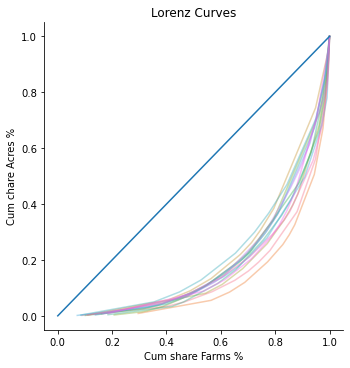

In [10]:
g = sns.relplot(x="farms_cum", y="acres_cum", kind="line", hue='fips_code',markers=True, alpha=0.4, data=dfsize1[(dfsize1['year']==2017) & (dfsize1['state_name']=='VERMONT')])
g._legend.remove()
plt.plot([0, 1], [0, 1], '')
g.set(title='Lorenz Curves', xlabel='Cum share Farms %', ylabel='Cum chare Acres %')



### Histogram of GINI Index

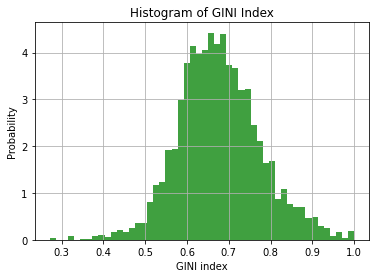

In [11]:
n, bins, patches = plt.hist(dfgini[dfgini['year']== 2017]['gini'], 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('GINI index')
plt.ylabel('Probability')
plt.title('Histogram of GINI Index')
plt.grid(True)
plt.show()

### County Map

In [12]:
# map_county(dfgini.loc[dfgini['year']== 2017], 'fips_code', 'gini', 'Gini Index of Farm Size', (0, 1), 'Viridis')


## Land Tenure: Agricultural Land, in Farm 2012, 2017

In [13]:
# For loop to merge data from different years

dfTen= pd.DataFrame(columns=['year','state_fips_code','state_name','county_ansi','county_name'])
# Parameters for Agriculture Land Tenure
agland_ten_params = {'key': key,
               'sector_desc': 'DEMOGRAPHICS',
               'commodity_desc': 'AG LAND',
               #'short_desc': ,
               'agg_level_desc': 'COUNTY',
               #'year':,
                }
#Owned Agriculture land
# for each tenure
for x in ['AG LAND, OWNED, IN FARMS - ACRES', 'AG LAND, RENTED FROM OTHERS, IN FARMS - ACRES']:
    agland_ten_params['short_desc']= x
    
    dften= pd.DataFrame()
    # For each year
    for y in [2012, 2017]:
        agland_ten_params['year']= y
        df= api_nass(agland_ten_params, key) # Call function to retrieve data
        df= df[['year','state_name','county_name','state_fips_code','county_ansi','Value']] # Select relevant variables
        # Convert Value (acres of land) to numeric
        df['Value']= df['Value'].str.replace(',', '')
        df['Value']= pd.to_numeric(df['Value'], errors='coerce')
        df.rename(columns={'Value': x[9:15]}, inplace=True) #Replace Value for Owned or Rented Column
        dften=dften.append(df, 'sort=False')
    # Complete database
    dfTen=dfTen.merge(dften, how='outer', on=['year','state_fips_code','state_name','county_ansi','county_name'])

In [14]:
#Create fips code for state+county
dfTen['fips_code'] = dfTen['state_fips_code']+dfTen['county_ansi']
dfTen['year']=dfTen['year'].astype(str) # convert year to string
dfTen= dfTen.sort_values(['year','fips_code'], ascending=True).reset_index(drop=True)
dfTen.rename(columns={'OWNED,': 'owned', 'RENTED': 'rented'}, inplace=True)

## Missing Values D replaced as zero
dfTen['owned']= dfTen['owned'].replace('D', 0)
dfTen['rented']= dfTen['rented'].replace('D', 0)
#New columns: proportion of land OWNED and RENTED
dfTen['tot_acres']= dfTen['owned'] + dfTen['rented']
dfTen['owned_prop']= dfTen['owned']/dfTen['tot_acres']
dfTen['rented_prop']= dfTen['rented']/dfTen['tot_acres']
dfTen['owned_prop']= dfTen['owned_prop'].replace(np.nan, 0)
dfTen['rented_prop']= dfTen['rented_prop'].replace(np.nan, 0)
dfTen

,year,state_name,county_name,state_fips_code,county_ansi,owned,rented,fips_code,tot_acres,owned_prop,rented_prop
0,2012,ALABAMA,AUTAUGA,01,001,14955.0,24864.0,01001,39819.0,0.375574,0.624426
1,2012,ALABAMA,BALDWIN,01,003,37309.0,59035.0,01003,96344.0,0.387248,0.612752
2,2012,ALABAMA,BARBOUR,01,005,24797.0,27866.0,01005,52663.0,0.470862,0.529138
3,2012,ALABAMA,BIBB,01,007,17078.0,5960.0,01007,23038.0,0.741297,0.258703
4,2012,ALABAMA,BLOUNT,01,009,29986.0,34981.0,01009,64967.0,0.461557,0.538443
...,...,...,...,...,...,...,...,...,...,...,...
6114,2017,WYOMING,SWEETWATER,56,037,NaN,NaN,56037,NaN,0.000000,0.000000
6115,2017,WYOMING,TETON,56,039,NaN,NaN,56039,NaN,0.000000,0.000000
6116,2017,WYOMING,UINTA,56,041,236578.0,178527.0,56041,415105.0,0.569923,0.430077
6117,2017,WYOMING,WASHAKIE,56,043,55481.0,38780.0,56043,94261.0,0.588589,0.411411


In [ ]:
#map_county(dfTen.loc[dfTen['year']== '2017'], 'fips_code', 'owned_prop', 'Ownership (Ag land, in farms %)', (0, 1), 'Viridis')
   

## Land Tenure: Harvested Croplands 2012, 2017

In [15]:
dfTenCrops= pd.DataFrame()

for y in [2012, 2017]:
    list_labels=[]
    # Parameters for land tenure data
    crops_params = {'key': key,
               'sector_desc': 'DEMOGRAPHICS',
               'commodity_desc': 'AG LAND',
               'domain_desc': 'TENURE',
               'class_desc': 'CROPLAND, HARVESTED',
               'agg_level_desc': 'COUNTY',
               'year': y,
                }
    df= api_nass(crops_params, key)
    df['Value']= df['Value'].str.replace(',', '')
    df['Value']= pd.to_numeric(df['Value'], errors='coerce')

    # Create columns for each tenure type and operations type
    #grouped= df.groupby(['domaincat_desc','unit_desc']) # Split the data sets
    dfc= pd.DataFrame(columns=['year','state_fips_code','state_name','county_ansi','county_name'])
    for x in (df['domaincat_desc'].unique().tolist()):
        for u in (df['unit_desc'].unique().tolist()):
            label=x[9:-1]+'_'+u
            list_labels.append(label)
            dfg= df.groupby(['domaincat_desc','unit_desc']).get_group((x,u)) # Split the data sets
            dfg.rename(columns={'Value': label}, inplace=True)
            
            filt=['year','state_name','county_name','state_fips_code','county_ansi',label]
            
            dfc=dfc.merge(dfg[filt], how='outer', on=['year','state_fips_code','state_name','county_ansi','county_name'])           
            
    dfTenCrops=dfTenCrops.append(dfc, 'sort=False')

/Users/elizabethespinosa/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [16]:
#Create fips code for state+county
dfTenCrops['fips_code'] = dfTenCrops['state_fips_code']+dfTenCrops['county_ansi']
dfTenCrops['year']=dfTenCrops['year'].astype(str) # convert year to string

dfTenCrops['tot_acres']= dfTenCrops['FULL OWNER_ACRES'] + dfTenCrops['PART OWNER_ACRES']+ dfTenCrops['TENANT_ACRES']
## Missing Values D replaced as zero
for z in list_labels[0:5]:
    dfTenCrops[z]= dfTenCrops[z].replace(np.nan, 0)

#New columns: proportion of land OWNED, PART Owned, and RENTED
dfTenCrops['owned_prop']= dfTenCrops['FULL OWNER_ACRES']/dfTenCrops['tot_acres']
dfTenCrops['part_prop']= dfTenCrops['PART OWNER_ACRES']/dfTenCrops['tot_acres']
dfTenCrops['rented_prop']= dfTenCrops['TENANT_ACRES']/dfTenCrops['tot_acres']
#dfTenCrops['owned_prop']= dfTenCrops['owned_prop'].replace(np.nan, 0)
#dfTenCrops['rented_prop']= dfTenCrops['rented_prop'].replace(np.nan, 0)
dfTenCrops

,year,state_name,county_name,state_fips_code,county_ansi,FULL OWNER_ACRES,FULL OWNER_OPERATIONS,PART OWNER_ACRES,PART OWNER_OPERATIONS,TENANT_ACRES,TENANT_OPERATIONS,fips_code,tot_acres,owned_prop,part_prop,rented_prop
0,2012,ALABAMA,COLBERT,01,033,9734.0,211.0,45538.0,121.0,1148.0,20.0,01033,56420.0,0.172527,0.807125,0.020347
1,2012,ALABAMA,FRANKLIN,01,059,10013.0,230.0,17828.0,157.0,461.0,14.0,01059,28302.0,0.353791,0.629920,0.016289
2,2012,ALABAMA,LAUDERDALE,01,077,15118.0,426.0,68597.0,283.0,2740.0,22.0,01077,86455.0,0.174866,0.793442,0.031693
3,2012,ALABAMA,LAWRENCE,01,079,11524.0,417.0,51925.0,260.0,31466.0,42.0,01079,94915.0,0.121414,0.547068,0.331518
4,2012,ALABAMA,LIMESTONE,01,083,13662.0,380.0,100883.0,248.0,19538.0,45.0,01083,134083.0,0.101892,0.752392,0.145716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6142,2017,WYOMING,NIOBRARA,56,027,10280.0,44.0,16462.0,33.0,1570.0,5.0,56027,28312.0,0.363097,0.581450,0.055454
6143,2017,WYOMING,PLATTE,56,031,25184.0,140.0,27021.0,66.0,7955.0,18.0,56031,60160.0,0.418617,0.449152,0.132231
6144,2017,NEW YORK,NEW YORK,36,061,0.0,0.0,4.0,4.0,3.0,3.0,36061,NaN,NaN,NaN,NaN
6145,2017,TEXAS,LOVING,48,301,0.0,0.0,0.0,1.0,0.0,NaN,48301,NaN,NaN,NaN,NaN


In [17]:
#map_county(dfTenCrops.loc[dfTenCrops['year']== '2017'], 'fips_code', 'rented_prop', 'Tenant (Harvested Crops %)', (0, 1), 'Viridis')


In [18]:
#map_county(dfTenCrops.loc[dfTenCrops['year']== '2017'], 'fips_code', 'part_prop', 'Part Ownership (Harvested Crops %)', (0, 1), 'Viridis')


In [19]:
#map_county(dfTenCrops.loc[dfTenCrops['year']== '2017'], 'fips_code', 'owned_prop', 'Total Ownership (Harvested Crops %)', (0, 1), 'Viridis')
